# Airbnb City Price Analysis
This project explores Airbnb listings across three major cities: Barcelona, Berlin and Paris. The goal is to identify main factors, which influence prices and find accommodation patterns.

## Project motivation
Understanding patterns and main factors for short-term rentals market. This information is highly valuable for hosts and investors.

The motivation for this project is to compare prices between different accommodations across multiple cities and find:
- how prices differ between cities
- which districts and accommodations are most expensive
- which factors have the strongest influence on price

## Data description
The data is sourced from InsideAirbnb website, which contains publicly available information about Airbnb listings.
The analysis focuses on 3 major cities:
- Barcelona
- Berlin
- Paris

For each city, the following variables are used:
- price
- room type
- neighborhood (district)
- minimum nights per stay
- number of reviews
- whether host is a superhost

In [1]:
import ast
from pathlib import Path
from collections import Counter
from scipy.stats import pointbiserialr, f_oneway, spearmanr

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

from umap import UMAP
from sklearn.cluster import DBSCAN, KMeans
from catboost import CatBoostRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Constants

In [2]:
DATA_DIR = Path("./data")
# CITIES = ["Berlin", "Paris", "Barcelona"]
CITIES = ["Barcelona", "Berlin", "Paris"]

# These columns should not be deleted during feature selection
IMPORTANT_COLUMNS = [
    "price",
    "latitude",
    "longitude",
    "city"
]

### Utilities

In [3]:
def rate_to_float(x) -> float:
    if isinstance(x, str) and (x is not np.nan):
        return int(str(x)[:-1]) / 100.0
    
    return x

### Step 1: data reading

In [4]:
# Read and unite the data
dfs = []
for city_name in CITIES:
    listings_path = DATA_DIR / f"listings_{city_name.lower()}.csv.gz"
    df = pd.read_csv(listings_path, compression = "gzip")
    df["city"] = city_name.lower()

    dfs.append(df)

df = pd.concat(dfs)

In [5]:
# Show basic info
print("Columns:", df.columns)
print("Shape:", df.shape)

for city, city_df in df.groupby("city"):
    print(f"\tShape ({city}):", city_df.shape)

Columns: Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_

In [6]:
df.head(10)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city
0,18674,https://www.airbnb.com/rooms/18674,20250914152803,2025-09-15,city scrape,Huge flat for 8 people close to Sagrada Familia,110m2 apartment to rent in Barcelona. Located ...,Apartment in Barcelona located in the heart of...,https://a0.muscache.com/pictures/13031453/413c...,71615,...,4.82,4.32,ESFCTU000008058000039706000000000000000HUTB-00...,t,26,26,0,0,0.34,barcelona
1,23197,https://www.airbnb.com/rooms/23197,20250914152803,2025-09-14,city scrape,"Forum CCIB DeLuxe, Spacious, Large Balcony, relax",Beautiful and Spacious Apartment with Large Te...,"Strategically located in the Parc del Fòrum, a...",https://a0.muscache.com/pictures/miso/Hosting-...,90417,...,4.66,4.68,ESFCTU000008106000547162000000000000000000HUTB...,f,1,1,0,0,0.52,barcelona
2,32711,https://www.airbnb.com/rooms/32711,20250914152803,2025-09-15,city scrape,Sagrada Familia area - Còrsega 1,A lovely two bedroom apartment only 250 m from...,What's nearby <br />This apartment is located...,https://a0.muscache.com/pictures/357b25e4-f414...,135703,...,4.89,4.47,HUTB-001722,f,2,2,0,0,0.88,barcelona
3,34241,https://www.airbnb.com/rooms/34241,20250914152803,2025-09-15,city scrape,Stylish Top Floor Apartment - Ramblas Plaza Real,Located in close proximity to Plaza Real and L...,NaN,https://a0.muscache.com/pictures/2437facc-2fe7...,73163,...,4.73,4.23,Exempt,f,3,3,0,0,0.14,barcelona
4,34981,https://www.airbnb.com/rooms/34981,20250914152803,2025-09-15,city scrape,VIDRE HOME PLAZA REAL on LAS RAMBLAS,Spacious apartment for large families or group...,"Located in Ciutat Vella in the Gothic Quarter,...",https://a0.muscache.com/pictures/c4d1723c-e479...,73163,...,4.65,4.46,ESFCTU000008119000093652000000000000000HUTB-00...,f,3,3,0,0,1.49,barcelona
5,36763,https://www.airbnb.com/rooms/36763,20250914152803,2025-09-15,previous scrape,In front of the beach,NaN,"The neighbordhood is just at the beach, very c...",https://a0.muscache.com/pictures/airflow/Hosti...,158596,...,4.92,4.82,NaN,f,1,0,1,0,0.64,barcelona
6,40983,https://www.airbnb.com/rooms/40983,20250914152803,2025-09-15,city scrape,Soho Colonial Eclectic Apartment,Our cool and stylish Loft Classical Apartment ...,"Is a perfect neighborhood, close to Paseo de G...",https://a0.muscache.com/pictures/miso/Hosting-...,177617,...,4.90,4.51,HUTB-001282,f,5,2,3,0,2.32,barcelona
7,49968,https://www.airbnb.com/rooms/49968,20250914152803,2025-09-15,city scrape,Sagrada Familia area - Còrsega 2,A very nice two bedroom apartment only 250 m f...,What's nearby <br />This apartment is located...,https://a0.muscache.com/pictures/82927561-3785...,135703,...,4.89,4.57,HUTB-001723,f,2,2,0,0,0.81,barcelona
8,68547,https://www.airbnb.com/rooms/68547,20250914152803,2025-09-15,city scrape,Spacious 2 bedroom flat special offer 40% OFF,The flat is located right in the historical ce...,"The flat is located two blocks from the sea, r...",https://a0.muscache.com/pictures/b4dd9551-b4fc...,340570,...,4.90,4.67,NaN,f,2,2,0,0,0.53,barcelona
9,71520,https://www.airbnb.com/rooms/71520,20250914152803,2025-09-14,city scrape,Charming apartment with fantastic views!,Anita's is a cozy lodging located in the foots...,NaN,https://a0.muscache.com/pictures/e7c5ed00-3cbe...,366428,...,4.00,5.00,HUTB-007966,f,1,1,0,0,0.01,barcelona


### Step 2: columns management

In [7]:
# Let's clean out out-of-scope or obviously useless columns

# Delete "_url"-suffixed columns
df.drop(
    columns=[col for col in df.columns if "_url" in col], 
    inplace=True,
    errors="ignore",
)

# Delete "id" and "_id"-suffixed columns
df.drop(
    columns=[col for col in df.columns if col.endswith("_id")] + ["id"],
    inplace=True,
    errors="ignore",
)

# # Delete other unrelated columns.
# # According to definitions described in supplementary materials:
# # https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?usp=sharing
# df.drop(
#     columns=[
#         "last_scraped",                 # Unrelated
#         "source",                       # Unrelated
#         "host_name",                    # Don't analyze host_name
#         "host_verifications",           # Unrelated
#         "bathrooms_text",               # Extra as 'bathrooms' already exists
#         "property_type"                 # Delete as simple eyeballing showed that it is just a complication of "room_type"
#         "neighbourhood",                # Already have more precise 'neighbourhood_cleaned'
#         "neighbourhood_group_cleansed"  # Redundant as it more abstract than 'neighbourhood_cleaned'
#     ],
#     inplace=True,
#     errors="ignore",
# )

In [8]:
# Print per-column dtype info
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 115537 entries, 0 to 81852
Data columns (total 72 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   last_scraped                                  115537 non-null  object 
 1   source                                        115537 non-null  object 
 2   name                                          115537 non-null  object 
 3   description                                   111525 non-null  object 
 4   neighborhood_overview                         55060 non-null   object 
 5   host_name                                     115498 non-null  object 
 6   host_since                                    115498 non-null  object 
 7   host_location                                 91304 non-null   object 
 8   host_about                                    56175 non-null   object 
 9   host_response_time                            75188 no

In [9]:
# Categorize each column by its type

# We will use only these columns according to definitions described in supplementary materials:
# https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?usp=sharing

DATE_COLUMNS = [
    "host_since", 
    "first_review", 
    "last_review",
    "last_scraped",
]

NUMERIC_INT_COLUMNS = [
    "accommodates",
    "bedrooms",
    "beds",
    "minimum_nights",
    "maximum_nights",
    "minimum_minimum_nights",
    "maximum_minimum_nights",
    "minimum_maximum_nights",
    "maximum_maximum_nights",
    "availability_30",
    "availability_60",
    "availability_90",
    "availability_365",
    "number_of_reviews",
    "number_of_reviews_ltm",
    "number_of_reviews_l30d",
    "calculated_host_listings_count",
    "calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms",
    "calculated_host_listings_count_shared_rooms",
]

NUMERIC_RAT_COLUMNS = [
    "latitude",
    "longitude",
    "bathrooms",
    "minimum_nights_avg_ntm",
    "maximum_nights_avg_ntm",
    "reviews_per_month",
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
]

BOOL_COLUMNS = [
    "host_is_superhost",
]

CATEGORICAL_COLUMNS = [
    "city",
    "amenities",
    "neighbourhood_cleansed",
    "room_type",
    "host_response_time",
]

In [10]:
# Cast date columns
for col in DATE_COLUMNS:
    df[col] = pd.to_datetime(df[col])

# Cast numeric (int) columns
for col in NUMERIC_INT_COLUMNS:
    try:
        df[col] = df[col].astype(np.int64)
    except:
        df[col] = df[col].astype("Int64")

# Cast numeric (rational) columns
for col in NUMERIC_RAT_COLUMNS:
    df[col] = df[col].astype(float)

# 'host_is_superhost' to bool
df["host_is_superhost"] = df["host_is_superhost"].apply(lambda x: True if x == "t" else False)

# 'host_acceptance_rate' and 'host_response_rate' to float
df["host_response_rate"] = df["host_response_rate"].replace({"%": ""}, regex=True).astype(float) / 100.
df["host_acceptance_rate"] = df["host_acceptance_rate"].replace({"%": ""}, regex=True).astype(float) / 100.

# 'host_listings_count' and 'host_total_listings_count' to integer
df["host_total_listings_count"] = df["host_total_listings_count"].astype("Int64")
df["host_total_listings_count"] = df["host_total_listings_count"].astype("Int64")

# Parse str->list 'amenities'
df["amenities"] = df["amenities"].apply(ast.literal_eval)

# Prepare 'price' col
df["price"] = df["price"].replace({"\$|,": ""}, regex=True).astype(float)

In [11]:
df = df[
    NUMERIC_INT_COLUMNS + \
    NUMERIC_RAT_COLUMNS + \
    DATE_COLUMNS + \
    CATEGORICAL_COLUMNS + \
    BOOL_COLUMNS + \
    ["price"]
]

df.head()

,accommodates,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,availability_30,...,first_review,last_review,last_scraped,city,amenities,neighbourhood_cleansed,room_type,host_response_time,host_is_superhost,price
0,8,3,6,1,1125,1,31,999,999,12,...,2013-05-27,2025-07-31,2025-09-15,barcelona,"[Pets allowed, 30 inch TV, Coffee maker, Eleva...",la Sagrada Família,Entire home/apt,within an hour,False,210.0
1,5,3,4,3,32,1,7,1125,1125,10,...,2011-03-15,2025-09-08,2025-09-14,barcelona,"[Electric stove, Toaster, Wine glasses, Bidet,...",el Besòs i el Maresme,Entire home/apt,within an hour,True,285.0
2,6,2,3,1,31,1,1,31,31,13,...,2011-07-17,2025-08-08,2025-09-15,barcelona,"[Coffee maker, Elevator, Patio or balcony, Car...",el Camp d'en Grassot i Gràcia Nova,Entire home/apt,within an hour,False,170.0
3,2,1,1,31,180,31,31,180,180,30,...,2010-07-10,2024-11-05,2025-09-15,barcelona,"[Toaster, Coffee maker, Bidet, Ethernet connec...",el Barri Gòtic,Entire home/apt,within an hour,False,110.0
4,9,4,6,5,365,2,5,1125,1125,10,...,2010-10-03,2025-08-19,2025-09-15,barcelona,"[Dryer, Cleaning available during stay, Coffee...",el Barri Gòtic,Entire home/apt,within an hour,False,333.0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115537 entries, 0 to 81852
Data columns (total 44 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   accommodates                                  115537 non-null  int64         
 1   bedrooms                                      96122 non-null   Int64         
 2   beds                                          24507 non-null   Int64         
 3   minimum_nights                                115537 non-null  int64         
 4   maximum_nights                                115537 non-null  int64         
 5   minimum_minimum_nights                        115515 non-null  Int64         
 6   maximum_minimum_nights                        115515 non-null  Int64         
 7   minimum_maximum_nights                        115515 non-null  Int64         
 8   maximum_maximum_nights                        115515 non-nul

### Step 3: basic price analysis

In [13]:
# Let's find and filter out NaN-priced accomodations
df[df["price"].isna()].shape, df[~df["price"].isna()].shape

((90997, 44), (24540, 44))

In [14]:
df = df.dropna(subset=["price"])

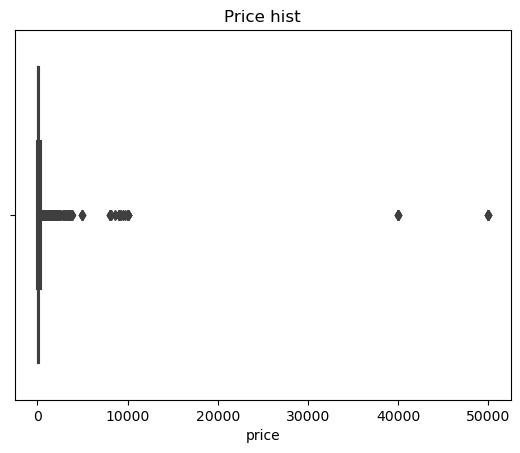

In [15]:
# Price box plot
plt.title("Price hist")
sns.boxplot(data=df, x="price");

## Data cleaning 
For the purposes of the analysis the data was cleaned:
- Price values were converted to numeric format
- Missing or invalid data was removed
- Outliers were removed using IQR (Interquartile Range) method

## Explanatory data analysis (EDA)
Explanatory data analysis was conducted to understand patterns in the data.

This includes:
- comparison of prices between cities
- analysis of accommodation types
- visualization of price distributions and factors using graphs
- analysis of relationship between price and other variables

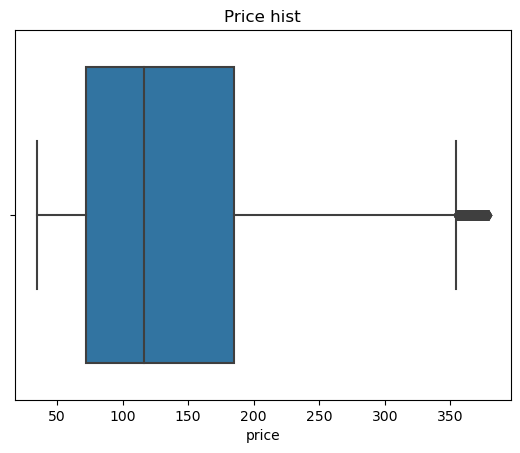

In [16]:
# As we could see from the boxplot price column has a lot of outliers.
# Let's filter them out with simple quantile step function and plot price one more time.
Q_95 = df["price"].quantile(0.95)
Q_05 = df["price"].quantile(0.05)
df = df[(Q_05 <= df["price"]) & (df["price"] < Q_95)]

plt.title("Price hist")
sns.boxplot(data=df, x="price");

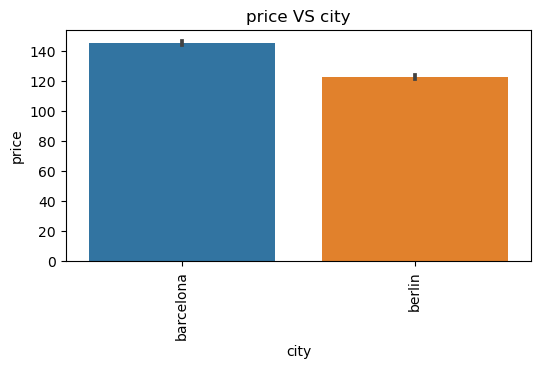

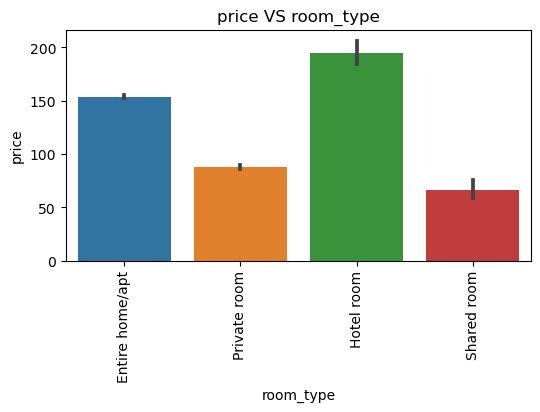

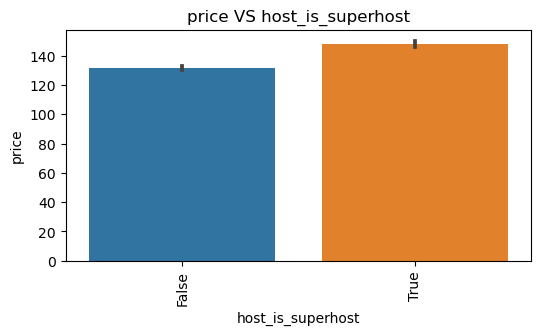

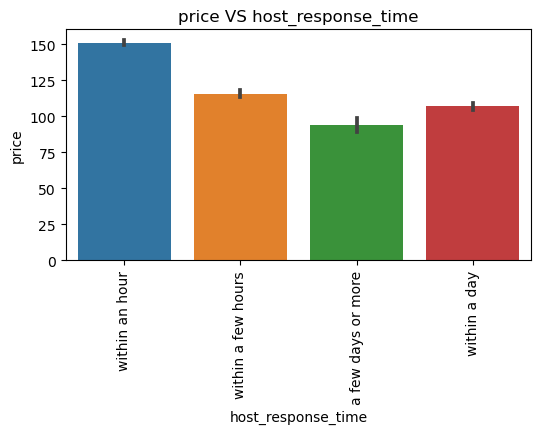

In [17]:
# Try to find out basic connection between price and categorical columns

cols_of_interest = [
    "city",
    "room_type",
    "host_is_superhost",
    "host_response_time",
]

nrows = len(cols_of_interest)

for i, col in enumerate(cols_of_interest):
    _, ax = plt.subplots(1, 1, figsize=(6, 3))
    ax.set_title(f"price VS {col}")
    ax.tick_params(axis="x", labelrotation=90) 
    sns.barplot(data=df.dropna(subset=[col]), x=col, y="price", ax=ax)  # computes averaged value per category by default

### Step 4: features preprossing

In [18]:
df.shape

(22219, 44)

In [19]:
# Create features dataframe
df_feats = pd.DataFrame()
df_feats[NUMERIC_INT_COLUMNS] = df[NUMERIC_INT_COLUMNS]
df_feats[NUMERIC_RAT_COLUMNS] = df[NUMERIC_RAT_COLUMNS]
df_feats[BOOL_COLUMNS] = df[BOOL_COLUMNS]
df_feats["price"] = df["price"]

df_feats.shape

(22219, 35)

In [20]:
# Encode categorical columns
dummy_columns = ["city", "host_response_time", "room_type", "neighbourhood_cleansed"]

for col in dummy_columns:
    dummies_df = pd.get_dummies(df[col], prefix=col).astype("Int8")
    df_feats[dummies_df.columns] = dummies_df
    # df_feats = df_feats.join(dummies_df, how="1:1")
    # df_feats = pd.concat([df_feats, dummies_df], axis=1)

df_feats.shape

(22219, 252)

In [21]:
# Preprocess 'amenities' column

# Choose top-100 amenities by frequency
amenities_counts = Counter([
    amenity.lower()
    for amenities in df["amenities"].tolist() 
    for amenity in amenities]
)
amenities_counts = list(sorted(amenities_counts.items(), key=lambda x: x[1]))[::-1][:100]
amenities, _ = zip(*amenities_counts)

# Walk through each listing and mark if it has corresponding amenity
dummy_amenity_vector = {f"amenity_{amenity.lower()}": 0 for amenity in amenities}

amenity_rows = []
for _, row in df.iterrows():
    current_amenity_vector = dummy_amenity_vector.copy()

    for amenity in row.amenities:
        if current_amenity_vector.get(f"amenity_{amenity.lower()}", None) is not None:
            current_amenity_vector[f"amenity_{amenity.lower()}"] = 1
    
    amenity_rows.append(current_amenity_vector)

amenity_df = pd.DataFrame(amenity_rows).astype("Int8")
df_feats[amenity_df.columns] = amenity_df

df_feats.shape

(22219, 352)

In [22]:
# Preprocess date columns with counting number of days since the value till 'last_scraped'
for col in DATE_COLUMNS:

    # Skip 'last_scraped' as it is pivot right now
    if col == "last_scraped":
        continue

    df_feats[col] = (df["last_scraped"] - df[col]).apply(lambda x: x.days).astype("Int64")

In [23]:
# Cast bool columns to Int
df_feats[BOOL_COLUMNS] = df[BOOL_COLUMNS].astype("Int8")

In [24]:
df_feats.shape

(22219, 355)

In [25]:
# Delete all NaNs
df_feats = df_feats.dropna()

df_feats.shape

(17369, 355)

In [26]:
# All features columns are numeric now
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17369 entries, 0 to 14236
Columns: 355 entries, accommodates to last_review
dtypes: Int64(9), Int8(318), float64(14), int64(14)
memory usage: 15.7 MB


### Step 5: correlation analisys and features filtering

## Statistical analysis
To better understand factors, which influence price basic statistical techniques were applied:
- correlation analysis between price and other factors
- linear regression analysis to estimate influence of factors on price

In [27]:
# Firstly let's delete constant columns
constant_columns = []
for col in df_feats.columns:
    values = df_feats[col].values
    if all(values[0] == values):
        constant_columns.append(col)

print(constant_columns)

df_feats = df_feats.drop(columns=constant_columns)

['neighbourhood_cleansed_Hellersdorf-Süd', 'neighbourhood_cleansed_Marzahn-Nord', 'neighbourhood_cleansed_la Trinitat Nova']


#### Numeric-to-Numeric correlation

In [28]:
num_columns = df_feats.select_dtypes(["Int16", "int64", "float64"]).columns

# We'll define correlation threshold to 0.9 (which equals to 0.95 corr score in normalized scale)
# We're not sure about whether we have feature outliers or not. 
# So we're using Spearman correlation as it is a rank-based correlation.
corr_df = df_feats[num_columns].corr(method="spearman")
bin_corr_df = corr_df > 0.9

high_corr_columns = bin_corr_df.stack()[bin_corr_df.stack() == True].index.tolist()
high_corr_columns = [pair for pair in high_corr_columns if pair[0] != pair[1]]
high_corr_columns = list(set([tuple(sorted(pair)) for pair in high_corr_columns]))

high_corr_columns

[('maximum_minimum_nights', 'minimum_nights_avg_ntm'),
 ('maximum_maximum_nights', 'maximum_nights_avg_ntm'),
 ('availability_60', 'availability_90'),
 ('maximum_nights_avg_ntm', 'minimum_maximum_nights')]

In [29]:
# Drop first element of each column pair
df_feats = df_feats.drop(columns=[pair[0] for pair in high_corr_columns if pair[0] not in IMPORTANT_COLUMNS])

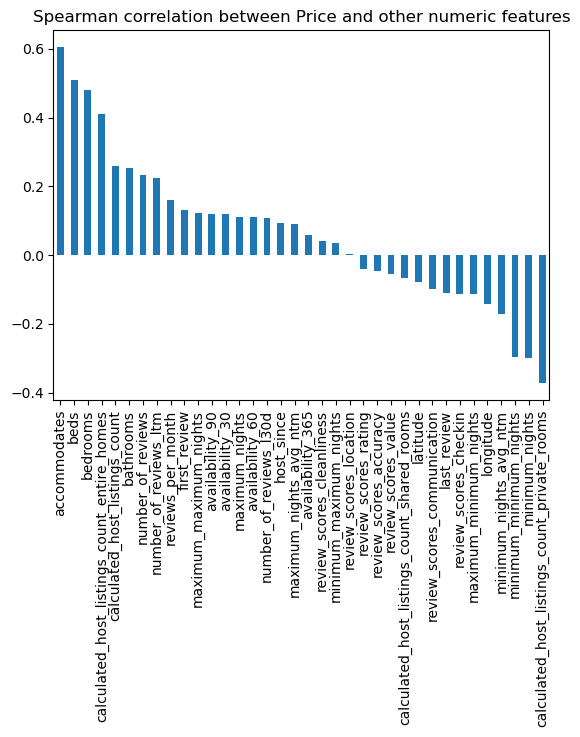

In [30]:
plt.title("Spearman correlation between Price and other numeric features")
corr_df["price"].sort_values(ascending=False)[1:].plot.bar();

#### Numeric-to-Binary

In [31]:
# Num-to-binary correlation analisys

high_corr_columns = []
for bin_col in df_feats.select_dtypes(["Int8"]).columns:
    for num_col in df_feats.select_dtypes(["Int16", "int64", "float64"]).columns:

        # Manual viewing showed there is no sub_dfs which lost more than ~3k rows after dropping
        sub_df = df_feats[[bin_col, num_col]].dropna()
        r, p = pointbiserialr(sub_df[bin_col], sub_df[num_col])

        # Choisen threshold=0.5 for highly correlated pairs of columns
        if r > 0.5:
            high_corr_columns.append((bin_col, num_col))

high_corr_columns

[('city_berlin', 'latitude'),
 ('city_berlin', 'longitude'),
 ('room_type_Shared room', 'calculated_host_listings_count_shared_rooms')]

In [32]:
high_corr_columns = [pair for pair in high_corr_columns if pair[0] != pair[1]]
high_corr_columns = list(set([tuple(sorted(pair)) for pair in high_corr_columns]))

high_corr_columns

[('city_berlin', 'latitude'),
 ('city_berlin', 'longitude'),
 ('calculated_host_listings_count_shared_rooms', 'room_type_Shared room')]

In [33]:
# Drop first element of each column pair
df_feats = df_feats.drop(columns=[pair[0] for pair in high_corr_columns if pair[0] not in IMPORTANT_COLUMNS])

#### Binary-to-Binary

In [34]:
# Binary-to-Binary

bin_columns = df_feats.select_dtypes(["Int8"]).columns.tolist()
corr_df = df_feats[bin_columns + ["price"]].corr("pearson")

# Thresholds using Pearson correlation on binary features are quite lowered compare to numeric ones.
bin_corr_df = corr_df > 0.6

high_corr_columns = bin_corr_df.stack()[bin_corr_df.stack() == True].index.tolist()
high_corr_columns = [pair for pair in high_corr_columns if pair[0] != pair[1]]
high_corr_columns = list(set([tuple(sorted(pair)) for pair in high_corr_columns]))

high_corr_columns

[('amenity_dining table', 'amenity_wine glasses'),
 ('amenity_self check-in', 'amenity_smart lock'),
 ('amenity_hot water kettle', 'amenity_toaster'),
 ('amenity_dishes and silverware', 'amenity_refrigerator'),
 ('amenity_crib', 'amenity_high chair')]

In [35]:
# Drop first element of each column pair
df_feats = df_feats.drop(columns=[pair[0] for pair in high_corr_columns if pair[0] not in IMPORTANT_COLUMNS])

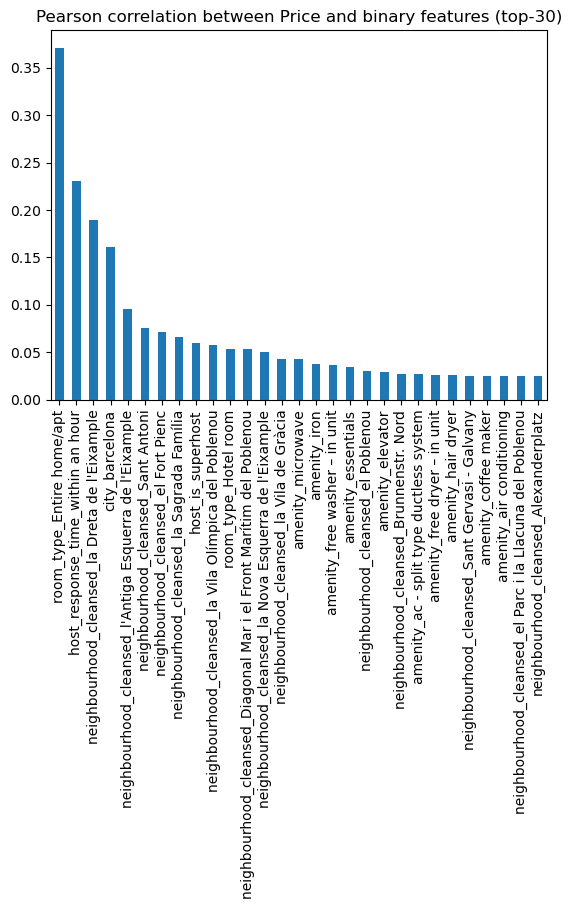

In [36]:
plt.title("Pearson correlation between Price and binary features (top-30)")
corr_df["price"].sort_values(ascending=False)[1:30].plot.bar();

In [37]:
# Final shape before 
df_feats.shape

(17369, 341)

### Step 6: regression analisys

In [38]:
# Prepare X, y
X_feats = df_feats.drop(columns=["price"]).values
y_feats = df_feats["price"].values

print(X_feats.shape, y_feats.shape)

(17369, 340) (17369,)


In [39]:
# Create pipeline and run training
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression()),
])

pipe.fit(X_feats, y_feats);

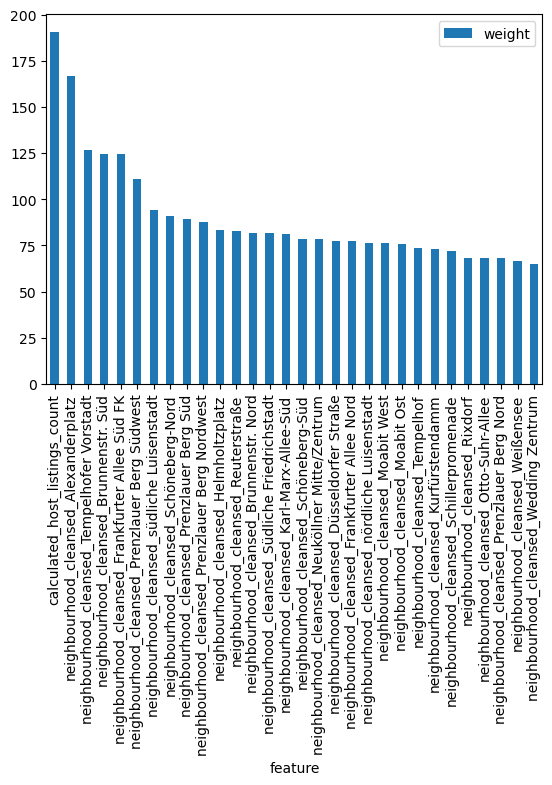

In [40]:
reg_df = pd.DataFrame()
reg_df["weight"] = pipe.named_steps["linreg"].coef_
reg_df["feature"] = df_feats.drop(columns=["price"]).columns


# Top-30 features by their impact on Price
reg_df.sort_values("weight", ascending=False).head(30).plot.bar(x="feature", y="weight");

In [41]:
# Let's compute r^2 coefficient
print("R^2 score:", r2_score(y_feats, pipe.predict(X_feats)))

R^2 score: 0.5492192352110015


### Step 7: fit a pricing model

In [42]:
# Firstly, let's divide data into train and test
train_df, test_df = train_test_split(
    df_feats, 
    train_size=0.9, 
    shuffle=True, 
    random_state=1703
)

X_train, y_train = train_df.drop(columns=["price"]).values, train_df["price"].values
X_test, y_test = test_df.drop(columns=["price"]).values, test_df["price"].values

In [43]:
# Prepare estimator and run fitting
estimator = CatBoostRegressor()
estimator.fit(X_train, y_train);

Learning rate set to 0.063217
0:	learn: 77.6297398	total: 289ms	remaining: 4m 48s
1:	learn: 75.2924789	total: 391ms	remaining: 3m 15s
2:	learn: 73.2019455	total: 493ms	remaining: 2m 43s
3:	learn: 71.2004698	total: 688ms	remaining: 2m 51s
4:	learn: 69.4280432	total: 794ms	remaining: 2m 37s
5:	learn: 67.8933036	total: 1.19s	remaining: 3m 16s
6:	learn: 66.3717888	total: 1.39s	remaining: 3m 17s
7:	learn: 64.9674607	total: 1.59s	remaining: 3m 16s
8:	learn: 63.7429981	total: 1.8s	remaining: 3m 18s
9:	learn: 62.6847703	total: 2.03s	remaining: 3m 20s
10:	learn: 61.6909297	total: 2.18s	remaining: 3m 16s
11:	learn: 60.7060393	total: 2.29s	remaining: 3m 8s
12:	learn: 59.8735908	total: 2.6s	remaining: 3m 17s
13:	learn: 59.0999445	total: 2.78s	remaining: 3m 15s
14:	learn: 58.3474933	total: 2.98s	remaining: 3m 15s
15:	learn: 57.6799141	total: 3.2s	remaining: 3m 16s
16:	learn: 57.0761017	total: 3.29s	remaining: 3m 10s
17:	learn: 56.5125702	total: 3.43s	remaining: 3m 7s
18:	learn: 55.9655586	total: 3.

In [44]:
# Run on test
y_pred = estimator.predict(X_test)

res_df = pd.DataFrame()
res_df["pred"] = y_pred
res_df["true"] = y_test

print("R^2 score:", r2_score(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

R^2 score: 0.7544876020773807
RMSE: 39.89737728547786


In [45]:
res_df.head(10)

,pred,true
0,105.786744,126.0
1,51.748047,56.0
2,81.083547,76.0
3,199.816137,250.0
4,242.723044,256.0
5,55.494715,60.0
6,132.964653,113.0
7,50.708546,66.0
8,172.047411,145.0
9,110.979665,47.0


In [46]:
# Extra: select top-10 features with Lasso Regression and then tune CatBoostRegressor one more time

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso())
])
pipe.fit(X_feats, y_feats)

weights = pipe.named_steps["lasso"].coef_
names = df_feats.drop(columns=["price"]).columns

weights_df = pd.DataFrame()
weights_df["w"] = weights
weights_df["name"] = names

top_10_important_features = weights_df.sort_values("w", ascending=False).head(10)["name"].tolist()
top_10_important_features

['accommodates',
 "neighbourhood_cleansed_la Dreta de l'Eixample",
 'review_scores_cleanliness',
 'availability_30',
 'bedrooms',
 'availability_90',
 "neighbourhood_cleansed_l'Antiga Esquerra de l'Eixample",
 'calculated_host_listings_count_entire_homes',
 'bathrooms',
 'neighbourhood_cleansed_Sant Antoni']

In [47]:
# Prepare one more data split and run regressor tuning
train_df, test_df = train_test_split(
    df_feats[top_10_important_features + ["price"]], 
    train_size=0.9, 
    shuffle=True, 
    random_state=1703
)

X_train, y_train = train_df.drop(columns=["price"]).values, train_df["price"].values
X_test, y_test = test_df.drop(columns=["price"]).values, test_df["price"].values

estimator = CatBoostRegressor()
estimator.fit(X_train, y_train);

# Run on test
y_pred = estimator.predict(X_test)

res_df = pd.DataFrame()
res_df["pred"] = y_pred
res_df["true"] = y_test

print("R^2 score:", r2_score(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

Learning rate set to 0.063217
0:	learn: 78.0084197	total: 87.4ms	remaining: 1m 27s
1:	learn: 76.2682989	total: 90.3ms	remaining: 45.1s
2:	learn: 74.6416271	total: 93.9ms	remaining: 31.2s
3:	learn: 73.0995023	total: 188ms	remaining: 46.9s
4:	learn: 71.7943827	total: 285ms	remaining: 56.7s
5:	learn: 70.5476071	total: 289ms	remaining: 47.9s
6:	learn: 69.4053887	total: 384ms	remaining: 54.5s
7:	learn: 68.3492793	total: 387ms	remaining: 48s
8:	learn: 67.3574862	total: 390ms	remaining: 42.9s
9:	learn: 66.4489256	total: 392ms	remaining: 38.9s
10:	learn: 65.6414238	total: 484ms	remaining: 43.6s
11:	learn: 64.9294042	total: 487ms	remaining: 40.1s
12:	learn: 64.2953522	total: 489ms	remaining: 37.1s
13:	learn: 63.7175672	total: 583ms	remaining: 41.1s
14:	learn: 63.1938239	total: 586ms	remaining: 38.5s
15:	learn: 62.6731296	total: 589ms	remaining: 36.2s
16:	learn: 62.1967767	total: 685ms	remaining: 39.6s
17:	learn: 61.7761707	total: 690ms	remaining: 37.7s
18:	learn: 61.4128303	total: 785ms	remaini

### Step 8: cluster analysis

#### Amenities vs Neighbourhood

In [ ]:
# At first lets take amenities columns, reduce dimensions 
# and try to find connection with price and neighbourhood manually.

amenities_columns = [col for col in df_feats.columns if "amenity_" in col]
amenities_data = df_feats[amenities_columns].dropna().values.astype(float)
print("Amenities shape:", amenities_data.shape)

# Reduce dimensionality up to 2 components using UMAP
n_components = 2
umap = UMAP(
    n_neighbors=8,
    n_components=n_components, 
    metric="manhattan",
    n_epochs=1000
)
amenities_data_reduced = umap.fit_transform(amenities_data)

# Create pivot df
amenities_df = pd.DataFrame(amenities_data_reduced, columns=[f"comp_{i}" for i in range(n_components)])
amenities_df["neighbourhood_cleansed"] = df["neighbourhood_cleansed"]

In [ ]:
# Visialize (with neighbourhood)
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(amenities_df, x="comp_0", y="comp_1", hue="neighbourhood_cleansed", ax=ax, s=20)
ax.legend(fontsize="9", title_fontsize="14", bbox_to_anchor=(2, 1.01), ncol=2);

In [ ]:
# As we can see from the plot above there is no obvious connection between components and neighbourhood.
# Let's reduce dimensionality to a higher order and try to find out this connection.

# Reduce dimensionality up to 20 components using UMAP
n_components = 20
umap = UMAP(
    n_neighbors=8,
    n_components=n_components, 
    metric="manhattan",
    n_epochs=1000
)
amenities_data_reduced = umap.fit_transform(amenities_data)

print("Dimensionality before:", amenities_data.shape[1])
print("Dimensionality after:", amenities_data_reduced.shape[1])

# Cluster them (DBSCAN)
clusterer = DBSCAN(eps=1.0, min_samples=3)
dbscan_clusters = clusterer.fit_predict(amenities_data_reduced)

clusterer = KMeans(n_clusters=df["neighbourhood_cleansed"].unique().shape[0])
kmeans_clusters = clusterer.fit_predict(amenities_data_reduced)

# Create cluster df
cluster_df = pd.DataFrame()
cluster_df["dbscan_cluster"] = dbscan_clusters
cluster_df["kmeans_cluster"] = kmeans_clusters
cluster_df["price"] = df_feats["price"]
cluster_df["neighbourhood_cleansed"] = df["neighbourhood_cleansed"]

cluster_df.head()

In [ ]:
# Visualize cluster-to-neighbourhood matrix

ct = pd.crosstab(cluster_df["neighbourhood_cleansed"], cluster_df["kmeans_cluster"])
ct_cluster_norm = ct.div(ct.sum(axis=0), axis=1)
ct_neighbour_norm = ct.div(ct.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(8.0, 6.5))
sns.heatmap(ct_cluster_norm, ax=ax);

# Ideally we are expecting to receive diagonal matrix (after sort).

In [ ]:
# Compute clusters cleanliness metrics

def entropy(p):
    # Simple entropy computation.
    # Smaller the number -> the more unique the category.
    
    p = p[p > 0]
    return -np.sum(p * np.log(p))


cluster_entropy = ct_neighbour_norm.apply(entropy, axis=0)

# Visualize entropy-per-cluster
fig, ax = plt.subplots(2, 1, figsize=(15, 6))
ax[0].set_title("Cluster entropy (smaller is better)")
sns.barplot(cluster_entropy, ax=ax[0]);
ax[0].tick_params(axis='x', labelrotation=90)

ax[1].set_title("Cluster purity (bigger is better)")
sns.barplot(ct_cluster_norm.max(axis=0))
ax[1].tick_params(axis='x', labelrotation=90)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

# As we can see below, our cluster analisys failed finding connection between amenities and neighbourhood:
# Cluster Entropy is not uniformly small among all the cluster.
# Cluster Purity is quite small almost everywhere the same way.

#### Other columns vs Neighborhood

In [ ]:
# Do the same for other columns (delete amenities)

# At first lets take other columns, reduce dimensions 
# and try to find connection with neighbourhood manually.

other_columns = [
    col for col in df_feats.columns 
    if ("amenity_" not in col) 
    and ("neighbourhood_cleansed" not in col)
]
other_data = df_feats[other_columns].dropna().values.astype(float)
print("Features shape:", other_data.shape)

# Reduce dimensionality up to 2 components using UMAP
n_components = 2
umap = UMAP(
    n_neighbors=8,
    n_components=n_components,
    n_epochs=1000
)
other_data_reduced = umap.fit_transform(other_data)

scaler = StandardScaler()
other_data_reduced = scaler.fit_transform(other_data_reduced)

# Create pivot df
other_df = pd.DataFrame(other_data_reduced, columns=[f"comp_{i}" for i in range(n_components)])
other_df["neighbourhood_cleansed"] = df["neighbourhood_cleansed"]

In [ ]:
# Visialize (with neighbourhood)
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(other_df, x="comp_0", y="comp_1", hue="neighbourhood_cleansed", ax=ax, s=20)
ax.legend(fontsize="9", title_fontsize="14", bbox_to_anchor=(2, 1.01), ncol=2);

In [ ]:
# We can see clean cluster clouds on the plot above. 
# Visually these clouds don't have any connection with neighbourhood column.
# Let's reduce dimensionality to a higher order and try to find out this connection.

# Reduce dimensionality up to 20 components using UMAP
n_components = 20
umap = UMAP(
    n_neighbors=8,
    n_components=n_components, 
    n_epochs=1000
)
other_data_reduced = umap.fit_transform(other_data)

print("Dimensionality before:", other_data.shape[1])
print("Dimensionality after:", other_data_reduced.shape[1])

# Cluster them (DBSCAN)
clusterer = DBSCAN(eps=1.0, min_samples=3)
dbscan_clusters = clusterer.fit_predict(other_data_reduced)

# Cluster them (KMeans)
clusterer = KMeans(n_clusters=df["neighbourhood_cleansed"].unique().shape[0])
kmeans_clusters = clusterer.fit_predict(other_data_reduced)

# Create cluster df
cluster_df = pd.DataFrame()
cluster_df["dbscan_cluster"] = dbscan_clusters
cluster_df["kmeans_cluster"] = kmeans_clusters
cluster_df["price"] = df_feats["price"]
cluster_df["neighbourhood_cleansed"] = df["neighbourhood_cleansed"]

cluster_df.head()

In [ ]:
# Visualize cluster-to-neighbourhood matrix

ct = pd.crosstab(cluster_df["neighbourhood_cleansed"], cluster_df["kmeans_cluster"])
ct_cluster_norm = ct.div(ct.sum(axis=0), axis=1)
ct_neighbour_norm = ct.div(ct.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(8.0, 6.5))
sns.heatmap(ct_cluster_norm, ax=ax);

# Ideally we are expecting to receive diagonal matrix (after sort).

In [ ]:
# Compute clusters cleanliness metrics

def entropy(p):
    # Simple entropy computation.
    # Smaller the number -> the more unique the category.
    
    p = p[p > 0]
    return -np.sum(p * np.log(p))


cluster_entropy = ct_neighbour_norm.apply(entropy, axis=0)

# Visualize entropy-per-cluster
fig, ax = plt.subplots(2, 1, figsize=(15, 6))
ax[0].set_title("Cluster entropy (smaller is better)")
sns.barplot(cluster_entropy, ax=ax[0]);
ax[0].tick_params(axis='x', labelrotation=90)

ax[1].set_title("Cluster purity (bigger is better)")
sns.barplot(ct_cluster_norm.max(axis=0))
ax[1].set_ylim(0.0, 1.0)
ax[1].tick_params(axis='x', labelrotation=90)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

# As we can see below, our cluster analisys failed finding connection between amenities and neighbourhood:
# Cluster Entropy is not uniformly small among all the cluster.
# Cluster Purity is quite small the same way.

#### Coordinates vs Price vs Neighbourhood

In [ ]:
# Extract and prepare coordinates
coords_df = df_feats[["latitude", "longitude"]]
# coords = np.radians(coords_df.values)
coords = coords_df.values

clusterer = DBSCAN(
    eps=0.003,     # 500 meters scale
    # metric="haversine"
    metric="manhattan"
)
clusters = clusterer.fit_predict(coords)

coords_df["cluster"] = clusters.astype(str)
coords_df["price"] = df_feats["price"]
coords_df["neighbourhood"] = df["neighbourhood_cleansed"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(coords_df, x="latitude", y="longitude", hue="cluster", s=10, ax=axes[0])
axes[0].set_title("coords vs cluster")

sns.scatterplot(coords_df, x="latitude", y="longitude", hue="price", s=10, ax=axes[1])
axes[1].set_title("coords vs price")

sns.scatterplot(coords_df, x="latitude", y="longitude", hue="neighbourhood", s=10, ax=axes[2]);
axes[2].set_title("coords vs neighbourhood")
axes[2].legend_ = None

### Step 9: provide hypothesis testing

In [ ]:
df.columns.tolist()

#### ANOVA: categorical factors vs price

In [ ]:
# Convert price to log scale as it has heavy-tail dist
df["log_price"] = np.log1p(df["price"])

def perform_anova_on_factors(df: pd.DataFrame, factor_col: str):
    # Prepare groups (filtering out small groups)
    groups = [group["log_price"].values for _, group in df.groupby(factor_col) if group.shape[0] > 20]

    # Perform ANOVA testing
    f_statistic, p_value = f_oneway(*groups)
    print("Factor:", factor_col)
    print("\tF-statistic:", f_statistic)
    print("\tP-value:", p_value)
    print("\tSanity check:")
    display(df.groupby(factor_col)["log_price"].agg(["mean", "median", "count", "std"]))

In [ ]:
factors_to_test = [
    "neighbourhood_cleansed", 
    "room_type", 
    "bedrooms",  # consider it as categorical one
    "bathrooms", # consider it as categorical one
    "accommodates",
    "host_is_superhost",
    "host_response_time"
]

for factor in factors_to_test:
    perform_anova_on_factors(df, factor)

In [ ]:
# As we can see the most significant factors are room_type and accomodates.

# Bathrooms (considered to be a categorical one there) has comparatevly small significance. 
# That is controversial according to earlier regression analisys. We can hypothesize on that like: 
# "There is a weird amount of listings with small price and lots of bathrooms. 
# It could be either statistical outlier or intentional misuse of service holes."

# Additionally as a potential host on Airbnb we can observe useful info about 'superhost' marking.
# It has comparatively significant positive connection with price.
# Latter is true for 'host_response_time' too.

#### Correlation: numeric factors vs price

In [ ]:
df_feats["log_price"] = np.log1p(df["price"])

def corr_with_price(factor_col: str) -> dict[str, float]:
    rho, p_value = spearmanr(
        df_feats["log_price"].astype(float),
        df_feats[factor_col].astype(float)
    )

    return {"factor": factor_col, "rho": rho}

In [ ]:
factors_to_test: list = df_feats.select_dtypes(["Int16", "Int64", "float64"]).columns.tolist()
factors_to_test.remove("price")
factors_to_test.remove("log_price")

corr_rows = []
for factor in factors_to_test:
    info = corr_with_price(factor)
    corr_rows.append(info)


spearman_df = pd.DataFrame(corr_rows)

spearman_df["sign"] = spearman_df["rho"].apply(lambda x: "neg" if x < 0 else "pos")
spearman_df["rho"] = abs(spearman_df["rho"])

spearman_df.sort_values("rho", ascending=False).head(10)

## Key findings
The analysis reveals several important insights:
- Average prices differ significantly between cities and districts
- Accommodation type and host being a superhost has a strong influence on price
- other factors are less significant, but still important
- number of reviews seem to have low correlation with price

From a business perspective, these findings can be used for investment decisions and pricing strategies.

## Limitations
This analysis has several limitations:
- The data represents only a snapshot in time and does not capture seasonal effects
- Some potentially important factors are excluded (amenities, etc.)
- Used data only focuses on major cities within Europe